In [1]:
from pyspark.sql import *
import pyspark.sql.functions as F
import pyspark.sql.types as T 
import string
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
get_ipython().run_line_magic('matplotlib', 'inline')

In [2]:
from pyspark.sql import SparkSession
import pyspark
sc = pyspark.SparkContext(appName="ToxicTwitterComments")
spark = pyspark.sql.SQLContext(sc)

# 1. Load data

In [3]:
trainDF = spark.read.csv('train.csv', 
                         header=True, 
                         multiLine=True, 
                         encoding="UTF-8",
                         sep=',',
                         escape='"',
                         inferSchema=True)

In [4]:
trainDF.printSchema()

root
 |-- id: string (nullable = true)
 |-- comment_text: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)



In [5]:
trainDF.createOrReplaceTempView('train')

In [6]:
spark.sql('''
SELECT * FROM train
limit(10)
''').toPandas()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


# 2. Data Cleaning

In [7]:
def clean(lines):
    lines = lines.lower().translate(str.maketrans('', '', string.punctuation))
    stop_words = list(set(stopwords.words('english')))
    stop_words.remove('not')
    word_tokens = word_tokenize(lines)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    cleaned_line = []
    for w in filtered_sentence:
        word = PorterStemmer().stem(w)
        cleaned_line.append(word)
    return ' '.join(cleaned_line)

In [8]:
clean("'Hey man, I'm really not trying to edit war.'")

'hey man im realli not tri edit war'

In [9]:
spark.udf.register("clean", clean, T.StringType())

<function __main__.clean>

In [10]:
df_train=spark.sql("""
SELECT clean(comment_text) cleaned_comment, toxic, severe_toxic,obscene,threat,insult,identity_hate
FROM train limit 20000
""")

#cleaning test data
df_test=spark.sql("""
SELECT clean(comment_text) cleaned_comment, toxic, severe_toxic,obscene,threat,insult,identity_hate
FROM test
LIMIT 15000
""")

In [11]:
# get a column of array<string> for word2vec
from pyspark.sql.functions import *
df_train2=df_train.withColumn("cleaned_comment2",split(df_train['cleaned_comment'], ' '))
#df_test2 = df_test.withColumn("cleaned_comment2",split(df_test['cleaned_comment'], ' '))

In [12]:
df_train2.show(2)

+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|     cleaned_comment|toxic|severe_toxic|obscene|threat|insult|identity_hate|    cleaned_comment2|
+--------------------+-----+------------+-------+------+------+-------------+--------------------+
|explan edit made ...|    0|           0|      0|     0|     0|            0|[explan, edit, ma...|
|daww match backgr...|    0|           0|      0|     0|     0|            0|[daww, match, bac...|
+--------------------+-----+------------+-------+------+------+-------------+--------------------+
only showing top 2 rows



In [13]:
df_train2.printSchema()

root
 |-- cleaned_comment: string (nullable = true)
 |-- toxic: integer (nullable = true)
 |-- severe_toxic: integer (nullable = true)
 |-- obscene: integer (nullable = true)
 |-- threat: integer (nullable = true)
 |-- insult: integer (nullable = true)
 |-- identity_hate: integer (nullable = true)
 |-- cleaned_comment2: array (nullable = true)
 |    |-- element: string (containsNull = true)



# Data Exploration

In [14]:
# most frequent word in toxic|severe_toxic|obscene|threat|insult|identity_hate comments
df_explore_toxic = df_train2.filter(df_train2.toxic != 0)
df_explore_severe_toxic = df_train2.filter(df_train2.severe_toxic != 0)
df_explore_obscene = df_train2.filter(df_train2.obscene != 0)
df_explore_threat = df_train2.filter(df_train2.threat != 0)
df_explore_insult = df_train2.filter(df_train2.insult != 0)
df_explore_identity_hate = df_train2.filter(df_train2.identity_hate != 0)

In [15]:
import os
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def wordcloud(df):
    d = {}
    for a, x in df.values:
        d[a] = x
    wordcloud = WordCloud()
    wordcloud.generate_from_frequencies(frequencies=d)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    return

In [16]:
df_explore_toxic = df_explore_toxic.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_toxic.show()

+-----------+-----+
|      words|count|
+-----------+-----+
|       fuck| 1833|
|     nigger| 1050|
|       ball|  857|
|         go|  847|
|          u|  811|
|        ass|  803|
|        sex|  721|
|        not|  692|
|       hate|  690|
|       like|  559|
|       cunt|  521|
|      moron|  431|
|         hi|  410|
|       dont|  403|
|        get|  368|
|       page|  351|
|bitchesfuck|  333|
|     sexsex|  332|
|  wikipedia|  325|
|    bollock|  323|
+-----------+-----+
only showing top 20 rows



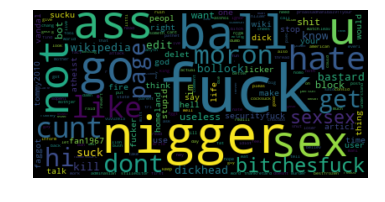

In [17]:
wordcloud(df_explore_toxic.toPandas())

In [18]:
df_explore_severe_toxic = df_explore_severe_toxic.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_severe_toxic.show()

+--------------------+-----+
|               words|count|
+--------------------+-----+
|                fuck| 1172|
|                 ass|  717|
|                   u|  682|
|                  go|  521|
|         bitchesfuck|  333|
|                kill|  257|
|            homeland|  227|
|        securityfuck|  227|
|             useless|  220|
|                 bot|  217|
|             bastard|  216|
|                suck|  206|
|                cunt|  201|
|               sucku|  191|
|             atheist|  178|
|                fire|  169|
|proassadhanibal91...|  134|
|                wiki|  125|
|              fucker|  118|
|              8dpeni|  118|
+--------------------+-----+
only showing top 20 rows



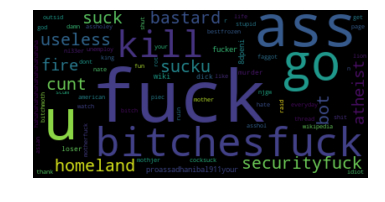

In [19]:
wordcloud(df_explore_severe_toxic.toPandas())

In [20]:
df_explore_obscene = df_explore_obscene.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_obscene.show()

+------------+-----+
|       words|count|
+------------+-----+
|        fuck| 1812|
|      nigger|  812|
|         ass|  808|
|           u|  762|
|          go|  651|
|        cunt|  519|
| bitchesfuck|  333|
|        like|  331|
|     bollock|  323|
|    dickhead|  322|
|         not|  312|
|        suck|  288|
|     bastard|  280|
|         get|  229|
|    homeland|  227|
|securityfuck|  227|
|        dont|  226|
|         bot|  225|
|     useless|  223|
|       sucku|  191|
+------------+-----+
only showing top 20 rows



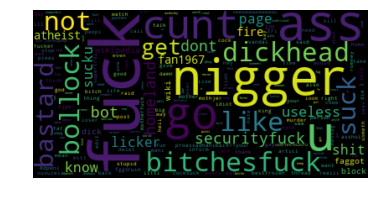

In [21]:
wordcloud(df_explore_obscene.toPandas())

In [22]:
df_explore_threat = df_explore_threat.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_threat.show()

+---------+-----+
|    words|count|
+---------+-----+
|      ass|  693|
|     kill|  270|
|       go|  214|
|   murder|  102|
|supertr0l|   46|
|      die|   43|
|     fuck|   31|
|     live|   30|
|     dont|   26|
|   pathet|   25|
|     fool|   24|
|    forev|   24|
|  respect|   23|
|       im|   19|
|        u|   13|
|     page|   12|
|     hope|   12|
|      get|   11|
|     time|   10|
|    bitch|    9|
+---------+-----+
only showing top 20 rows



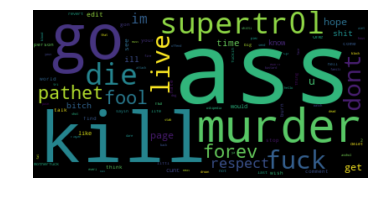

In [23]:
wordcloud(df_explore_threat.toPandas())

In [24]:
df_explore_insult = df_explore_insult.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_insult.show()

+-----------+-----+
|      words|count|
+-----------+-----+
|       fuck| 1569|
|     nigger|  856|
|        ass|  773|
|          u|  763|
|       hate|  579|
|       cunt|  506|
|         go|  505|
|      moron|  418|
|         hi|  395|
|bitchesfuck|  333|
|   dickhead|  322|
|       like|  295|
|        not|  252|
|    bastard|  242|
|  tommy2010|  227|
|        bot|  225|
|    useless|  225|
|       suck|  200|
|        get|  195|
|      sucku|  191|
+-----------+-----+
only showing top 20 rows



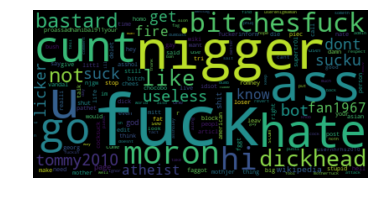

In [25]:
wordcloud(df_explore_insult.toPandas())

In [26]:
df_explore_identity_hate = df_explore_identity_hate.select(F.explode("cleaned_comment2").alias("words")).groupBy("words").count().orderBy(desc("count"))
df_explore_identity_hate.show()

+-------------+-----+
|        words|count|
+-------------+-----+
|       nigger| 1044|
|         cunt|  285|
|    tommy2010|  227|
|       licker|  178|
|      fan1967|  178|
|         like|  142|
|         homo|   90|
|       romney|   87|
|         mitt|   87|
|         fuck|   83|
|         hate|   75|
|          gay|   60|
|     american|   56|
|         scum|   53|
|         piec|   53|
|        asian|   51|
|       nl33er|   50|
|usernhrhs2010|   44|
|userenigmaman|   43|
|         dont|   32|
+-------------+-----+
only showing top 20 rows



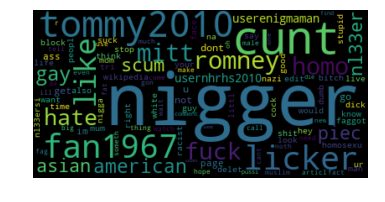

In [27]:
wordcloud(df_explore_identity_hate.toPandas())

# 3. Feature Engineering

## 3.1 Word2Vec

In [32]:
from pyspark.ml.feature import Word2Vec
from pyspark.ml import Pipeline

word2Vec = Word2Vec(vectorSize=30, seed=42, inputCol="cleaned_comment2", outputCol="features")
model = word2Vec.fit(df_train2)
model.getVectors().show()
wvfeature = model.transform(df_train2)


pipeline_w2v = Pipeline(stages=[word2Vec])
pipelineModel_w2v = pipeline_w2v.fit(df_train2)
wvfeature = pipelineModel_w2v.transform(df_train2)
#wvfeature_test = pipelineModel_w2v.transform(df_test2)

+--------------------+--------------------+
|                word|              vector|
+--------------------+--------------------+
|            incident|[0.00993952434509...|
|             serious|[-0.0287756826728...|
|             acronym|[-0.0166651327162...|
|             miracul|[0.00345667195506...|
|           forgotten|[0.03824589774012...|
|               mario|[4.06572886276990...|
|              justif|[-0.0766370296478...|
|          compliment|[0.01203599199652...|
|           prehistor|[0.01341573800891...|
|          lithuanian|[-0.0431885756552...|
|proassadhanibal91...|[0.70147883892059...|
|               lover|[-0.0414681509137...|
|              comedi|[0.03649429604411...|
|              rovoam|[-2.9025878757238...|
|          corpsefuck|[0.05921789631247...|
|           regularli|[-0.0744669958949...|
|               fanci|[-0.0077614611946...|
|                elit|[0.01203933916985...|
|             speaker|[0.13487206399440...|
|                lion|[0.9004596

In [35]:
word = 'hate'
topN = 20

synonymsDF = model.findSynonyms(word, topN).toPandas()

In [36]:
synonymsDF[['word']].head(topN)

,word
0,nl33er
1,nl33ersi
2,e
3,hathat
4,ugh
5,fck
6,wa
7,stalin
8,deist
9,imput


In [37]:
wordVectorsDF = model.getVectors()
from pyspark.ml.feature import PCA
dfW2V = wordVectorsDF.select('vector').withColumnRenamed('vector','features')

numComponents = 3
pca = PCA(k = numComponents, inputCol = 'features', outputCol = 'pcaFeatures')
model = pca.fit(dfW2V)
dfComp = model.transform(dfW2V).select("pcaFeatures")

In [38]:
dfComp.show()

+--------------------+
|         pcaFeatures|
+--------------------+
|[0.13542903456873...|
|[0.27050224482286...|
|[-0.0530982308089...|
|[-0.0251619973911...|
|[0.05348111556695...|
|[-0.2472295008137...|
|[0.47541288641762...|
|[0.11512654258274...|
|[-0.0714011290589...|
|[0.18825030382988...|
|[-3.0530292432428...|
|[-0.1047168087271...|
|[-0.0849874716853...|
|[0.04089967501375...|
|[-0.2175672171134...|
|[0.12129545100472...|
|[0.02435829628720...|
|[0.00488502835572...|
|[-0.1149459318285...|
|[-2.5052971431501...|
+--------------------+
only showing top 20 rows



In [39]:
def topNwordsToPlot(dfComp,wordVectorsDF,word,nwords):
    compX = np.asarray(dfComp.map(lambda vec: vec[0][0]).collect())
    compY = np.asarray(dfComp.map(lambda vec: vec[0][1]).collect())
    compZ = np.asarray(dfComp.map(lambda vec: vec[0][2]).collect())

    words = np.asarray(wordVectorsDF.select('word').toPandas().values.tolist())
    Feat = np.asarray(wordVectorsDF.select('vector').rdd.map(lambda v: np.asarray(v[0])).collect())

    Nw = words.shape[0]                # total number of words
    ind_star = np.where(word == words) # find index associated to 'word' 
    wstar = Feat[ind_star,:][0][0]     # vector associated to 'word'
    nwstar = math.sqrt(np.dot(wstar,wstar)) # norm of vector assoicated with 'word'

    dist = np.zeros(Nw) # initialize vector of distances
    i = 0
    for w in Feat: # loop to compute cosine distances between 'word' and the rest of the words 
        den = math.sqrt(np.dot(w,w))*nwstar  # denominator of cosine distance
        dist[i] = math.fabs( np.dot(wstar,w) )/den   # cosine distance to each word
        i = i + 1

    indexes = np.argpartition(dist,-(nwords+1))[-(nwords+1):]
    di = []
    for j in range(nwords+1):
        di.append(( words[indexes[j]], dist[indexes[j]], compX[indexes[j]], compY[indexes[j]], compZ[indexes[j]] ) )

    result=[]
    for elem in sorted(di,key=lambda x: x[1],reverse=True):
        result.append((elem[0][0], elem[2], elem[3], elem[4]))
    
    return pd.DataFrame(result,columns=['word','X','Y','Z'])

In [40]:
dfComp = dfComp.select('pcaFeatures').rdd

/Users/Shelly/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


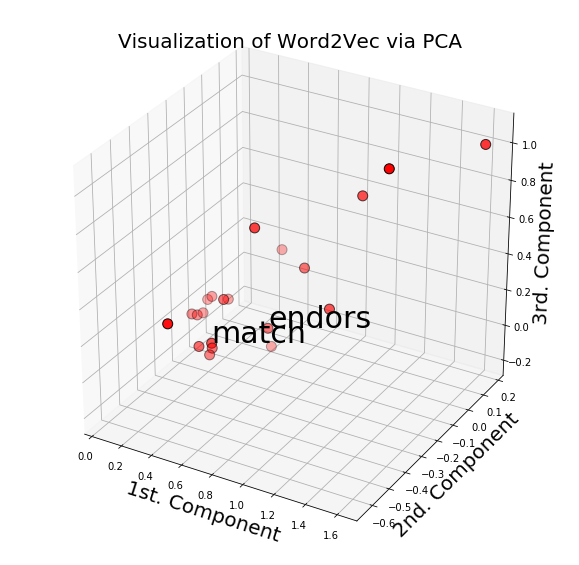

In [41]:
word = 'match'
nwords = 20
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#############
import math
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
r = topNwordsToPlot(dfComp,wordVectorsDF,word,nwords)

############
fs=20 #fontsize
w = r['word']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

height = 10
width = 10
fig.set_size_inches(width, height)

ax.scatter(r['X'], r['Y'], r['Z'], color='red', s=100, marker='o', edgecolors='black')
for i, txt in enumerate(w):
    if(i<2):
        ax.text(r['X'].ix[i],r['Y'].ix[i],r['Z'].ix[i], '%s' % (txt), size=30, zorder=1, color='k')
    #if((i==4) or (i==5)):
    #    ax.text(r['X'].ix[i],r['Y'].ix[i],r['Z'].ix[i], '%s' % (txt), size=30, zorder=1, color='k')    
ax.set_xlabel('1st. Component', fontsize=fs)
ax.set_ylabel('2nd. Component', fontsize=fs)
ax.set_zlabel('3rd. Component', fontsize=fs)
ax.set_title('Visualization of Word2Vec via PCA', fontsize=fs)
ax.grid(True)
plt.show()

In [42]:
from pyspark.ml.clustering import KMeans
vocabSize = wordVectorsDF.count()
K = int(math.floor(math.sqrt(float(vocabSize)/2)))
         # K ~ sqrt(n/2) this is a rule of thumb for choosing K,
         # where n is the number of words in the model
         # feel free to choose K with a fancier algorithm

dfW2V = wordVectorsDF.select('vector').withColumnRenamed('vector','features')
kmeans = KMeans(k=K, seed=1)
modelK = kmeans.fit(dfW2V)
labelsDF = modelK.transform(dfW2V).select('prediction').withColumnRenamed('prediction','labels')

print("Number of Clusters (K) Used: ", K)

Number of Clusters (K) Used:  67


Now we get the Word2Vec features， we can follow the procedure like TF-IDF to build another model and compare the performance. 

## 3.2 TF-IDF

# 4. Data Spliting 

# 5. Modelling (LR)

## 5.1 Train

## 5.2 Prediction